# Create a polynomial chaos metamodel

In this basic example we are going to create a global approximation of a model response using functional chaos.

Here

$$h(x) = [\cos(x_1 + x_2), (x2 + 1) e^{x_1 - 2 x_2}]$$

In [7]:
from __future__ import print_function
import openturns as ot

In [8]:
# prepare some X/Y data
ot.RandomGenerator.SetSeed(0)
dimension = 2
input_names = ['x1', 'x2']
formulas = ['cos(x1 + x2)', '(x2 + 1) * exp(x1 - 2 * x2)']
model = ot.SymbolicFunction(input_names, formulas)
distribution = ot.Normal(dimension)
x  = distribution.getSample(30)
y = model(x)

In [9]:
# create a functional chaos model
# we reduce the sampling size for the automatic selection of distribution based on Kolmogorov test
ot.ResourceMap.SetAsUnsignedInteger("FittingTest-KolmogorovSamplingSize", 4)
algo = ot.FunctionalChaosAlgorithm(x, y)
algo.run()
result = algo.getResult()
responseSurface = result.getMetaModel()

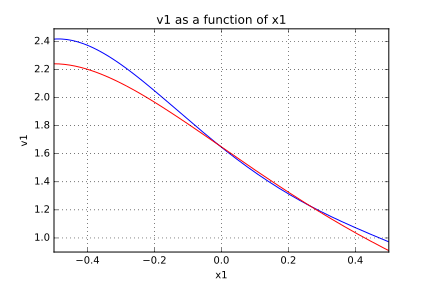

In [12]:
# plot 2nd output of our model with x1=0.5
graph = ot.ParametricFunction(responseSurface, [0], [0.5]).getMarginal(1).draw(-0.5, 0.5)
curve = ot.ParametricFunction(model, [0], [0.5]).getMarginal(1).draw(-0.5, 0.5).getDrawable(0)
curve.setColor('red')
graph.add(curve)
graph

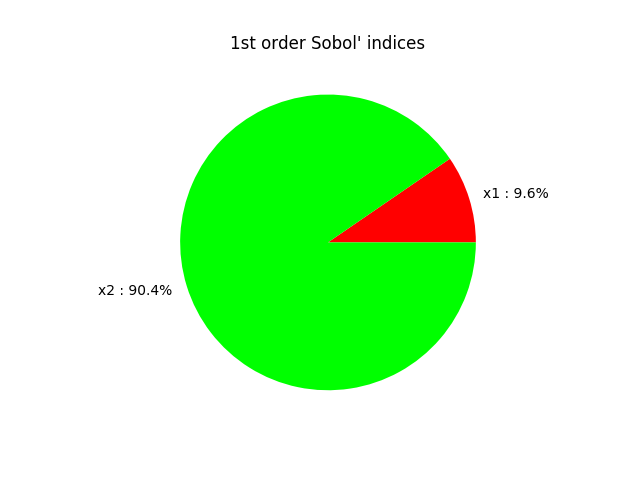

In [10]:
# draw Sobol' indices
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
first_order = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
ot.SaltelliSensitivityAlgorithm.DrawImportanceFactors(first_order, input_names, '1st order Sobol\' indices')